# Population Estimation Pipeline

## Setup

### General imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
from osgeo import gdal, osr, ogr
from tifffile import imread
from tqdm import tqdm

In [3]:
from functions.visualization import to_img, display_pair, get_tiles, get_tiles_df

### Parameters

In [4]:
SEED = 42
np.random.seed(SEED)
prng = np.random.RandomState(SEED)

In [5]:
tiles_path = './survey_tiles/'

#### Survey rasterization

In [6]:
survey_data_path = './Mozambique Dataset 1/Mozambique samples/'
boa_srs_path = './Mozambique Dataset 1/Mozambique empty grids/BOA_adm_gridcentroids-100m.shp'
mgd_srs_path = './Mozambique Dataset 1/Mozambique empty grids/MGD_adm_gridcentroids-100m.shp'
boa_survey_path = './Survey/boa_survey.tif'
mgd_survey_path = './Survey/mgd_survey.tif'

#### Building footprint estimation

In [7]:
model_path = './models/spacesur/model.json'
weights_path = './models/spacesur/model.h5'
boa_footprints_path = './buildings/spaceSUR/pred/boa/'
mgd_footprints_path = './buildings/spaceSUR/pred/boa/'

#### Outliers

In [8]:
boa_outliers_path = './outliers/boa_outliers.csv'
mgd_outliers_path = './outliers/mgd_outliers.csv'

#### Population estimation

In [9]:
features = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3',
       'landsat_b4', 'landsat_b5', 'landsat_b6', 'landsat_b7',
       'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
       'road_dist_m', 'building_area_spacesur', 'no_class',
       'closed_forest', 'open_forest', 'shrubs', 'hb_veg', 'hb_waste',
       'moss', 'bare', 'cropland', 'urban', 'snow', 'water', 'sea',
       'landsat_b0_context', 'landsat_b1_context', 'landsat_b2_context',
       'landsat_b3_context', 'landsat_b4_context', 'landsat_b5_context',
       'landsat_b6_context', 'landsat_b7_context', 'landsat_b8_context',
       'landsat_b9_context', 'ndvi_context', 'ndwi_context',
       'ntl_context', 'hrsl_context', 'road_dist_m_context',
       'building_area_spacesur_context', 'no_class_context',
       'closed_forest_context', 'open_forest_context', 'shrubs_context',
       'hb_veg_context', 'hb_waste_context', 'moss_context',
       'bare_context', 'cropland_context', 'urban_context',
       'snow_context', 'water_context', 'sea_context'])

In [10]:
target = np.array(['pop'])

In [11]:
log = True

## Rasterize survey

In [13]:
from functions.survey import df_to_raster, display_surveys, get_extent

### Load data

In [14]:
df_raw_boa = pd.read_stata(survey_data_path + 'sample_boa.dta')
df_raw_mgd = pd.read_stata(survey_data_path + 'sample_mgd.dta')

### Rasterize

In [15]:
# Compute and export geotiff population rasters from survey data
df_to_raster(df_raw_boa,boa_survey_path,boa_srs_path,'members_n')
df_to_raster(df_raw_mgd,mgd_survey_path,mgd_srs_path,'members_n')

In [16]:
# Compute and export geotiff building count rasters from survey data
df_to_raster(df_raw_boa,'./Survey/boa_count.tif',boa_srs_path,'count_buildings')
df_to_raster(df_raw_mgd,'./Survey/mgd_count.tif',mgd_srs_path,'count_buildings')

In [17]:
pop_boa = imread(boa_survey_path)
pop_mgd = imread(mgd_survey_path)

## Estimate building footprints

In [18]:
from functions.footprints import load_model, estimate_footprints

In [19]:
model = load_model(model_path,weights_path)

In [21]:
estimate_footprints(pop_boa,'./maxar_boa/',boa_footprints_path,model,threshold=0.9)
estimate_footprints(pop_mgd,'./maxar_mgd/',mgd_footprints_path,model,threshold=0.9)

Learning channel-wise distribution for imagery in ./maxar_boa/


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.99it/s]

Predicting building footprints for survey tiles in ./maxar_boa/



100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:20<00:00, 14.01it/s]


Learning channel-wise distribution for imagery in ./maxar_mgd/


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.43it/s]

Predicting building footprints for survey tiles in ./maxar_mgd/



100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:14<00:00, 12.71it/s]


## Preprocess feature rasters

In [22]:
from functions.data import *
from functions.preprocessing import *

### Load data and construct dataset

In [23]:
rasters_boa = load_rasters('boa') 
rasters_mgd = load_rasters('mgd')

In [24]:
feature_names = get_feature_names()

In [25]:
df_boa = construct_dataset(feature_names,rasters_boa,pop_boa,context=True) # 50, 275
df_mgd = construct_dataset(feature_names,rasters_mgd,pop_mgd,context=True) # 230, 490

### Split data into validation folds and save to file

In [26]:
df_boa = label_folds(get_val_split(df_boa))
df_mgd = label_folds(get_val_split(df_mgd))

In [27]:
# Write to disk
df_boa.to_csv('./csv/boa.csv',index=False)
df_mgd.to_csv('./csv/mgd.csv',index=False)

### Remove outliers

In [28]:
from functions.data import remove_outliers

In [29]:
len(df_boa) + len(df_mgd)

474

In [30]:
df_boa = remove_outliers(df_boa,boa_outliers_path,strong_only=False)
df_mgd = remove_outliers(df_mgd,mgd_outliers_path,strong_only=False)

In [31]:
df_boa['roi'] = 'boa' # for visualization
df_mgd['roi'] = 'mgd' # for visualization
df_boa['roi_num'] = 0 # for model
df_mgd['roi_num'] = 1 # for model
df = df_boa.append(df_mgd,ignore_index=True).sort_values(by='fold', ascending=True).reset_index(drop=True) # sort by fold
display(df)

,x,y,landsat_b0,landsat_b1,landsat_b2,landsat_b3,landsat_b4,landsat_b5,landsat_b6,landsat_b7,...,bare_context,cropland_context,urban_context,snow_context,water_context,sea_context,pop,fold,roi,roi_num
0,118,11,10895.223633,10156.565430,9782.320312,10134.708008,15702.265625,17839.257812,15277.496094,9858.237305,...,0.0,1.000000,0.000000,0.0,0.0,0.0,3.0,0,boa,0
1,104,148,11151.789062,10461.655273,10356.648438,11213.542969,17231.845703,18977.359375,16206.482422,10622.944336,...,0.0,0.555556,0.000000,0.0,0.0,0.0,7.0,0,boa,0
2,291,446,9176.956055,8613.373047,8232.438477,8715.929688,10781.729492,11988.632812,10756.526367,8419.846680,...,0.0,0.777778,0.000000,0.0,0.0,0.0,7.0,0,mgd,1
3,130,40,8944.000000,8332.995117,7863.830078,8275.438477,10533.853516,12410.594727,10704.127930,7950.947754,...,0.0,0.111111,0.222222,0.0,0.0,0.0,11.0,0,mgd,1
4,130,42,8970.413086,8370.429688,7857.674805,8142.222168,10689.382812,12454.527344,10273.217773,7892.323730,...,0.0,0.777778,0.000000,0.0,0.0,0.0,3.0,0,mgd,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,148,218,11462.326172,10779.148438,10503.547852,10608.528320,16982.816406,15827.172852,12925.557617,10489.564453,...,0.0,0.000000,1.000000,0.0,0.0,0.0,17.0,3,boa,0
284,147,218,11307.667969,10578.583008,10259.977539,10096.094727,17196.335938,15113.315430,11946.597656,10156.680664,...,0.0,0.000000,1.000000,0.0,0.0,0.0,12.0,3,boa,0
285,158,215,11215.201172,10471.555664,10224.971680,10226.047852,17099.632812,15772.015625,12450.642578,10213.514648,...,0.0,0.000000,0.555556,0.0,0.0,0.0,21.0,3,boa,0
286,122,246,11561.772461,10944.502930,10959.352539,11663.037109,16820.664062,17272.595703,14589.453125,11144.351562,...,0.0,0.000000,0.888889,0.0,0.0,0.0,22.0,3,boa,0


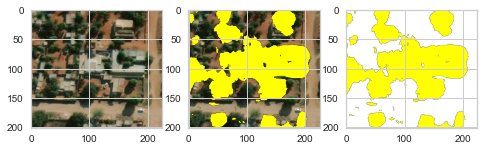

In [32]:
f, axarr = plt.subplots(1,3,figsize=(8,3))
img, buildings = get_tiles_df(df,200,tiles_path)
buildings = to_img(buildings)
display_pair(img,buildings,axarr)

## Estimate Population

### Imports

In [33]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import feature_importances

Our error metric is median absolute percent error ($MeAPE$), which is more resistant to outliers than the mean:

$\begin{align}
MeAPE = median(X) \text{ where } X = \left\{ \left\lvert \frac{y_i - \hat{y_i}}{y_i} \right\rvert \text{ for } i = 1,2,3,...,n \right\}
\end{align}$

In [34]:
from functions.prediction import cross_val
from functions.visualization import prediction_error
from functions.scoring import meape, accuracy

In [35]:
plt.style.use('ggplot')

In [36]:
y_true = df[target].to_numpy()

### Fit Poisson regression model

In [37]:
pr = PoissonRegressor(max_iter=200)
reg_pr = GridSearchCV(pr,{'alpha':np.linspace(0.1,1,50)},scoring=make_scorer(meape,greater_is_better=False),cv=3,n_jobs=-1)
y_pred_pr, models_pr = cross_val(reg_pr,df,features,target,log=log,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
Training on 213 samples, validating on 75, 74/26 split
Training on 214 samples, validating on 74, 74/26 split
Training on 217 samples, validating on 71, 75/25 split


In [38]:
bands = [(0,5),(5,15),(15,30),(30,50),(50,100)]
#bands = [(0,10),(10,30),(30,100)]
accuracy(y_true,y_pred_pr,bands)

0.5208333333333334

### Fit random forest regression model

In [39]:
rf = RandomForestRegressor(n_jobs=-1,random_state=prng)
param_grid = {'n_estimators': list(range(100,1200,200)), # list(range(200,1200,200)
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}
reg_rf = GridSearchCV(rf,param_grid,scoring=make_scorer(meape,greater_is_better=False),cv=3,verbose=0,n_jobs=-1)
y_pred_rf, models_rf = cross_val(reg_rf,df,features,target,log=log,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
Training on 213 samples, validating on 75, 74/26 split
Training on 214 samples, validating on 74, 74/26 split
Training on 217 samples, validating on 71, 75/25 split


In [40]:
bands = [(0,5),(5,15),(15,30),(30,50),(50,100)]
#bands = [(0,10),(10,30),(30,100)]
accuracy(y_true,y_pred_rf,bands)

0.5555555555555556

### Define dummy predictions

In [42]:
y_pred_dummy = np.full(y_true.shape[0],7)

## Evaluate Estimates

Text(0.5, 1.0, 'Dummy (all predictions 7)')

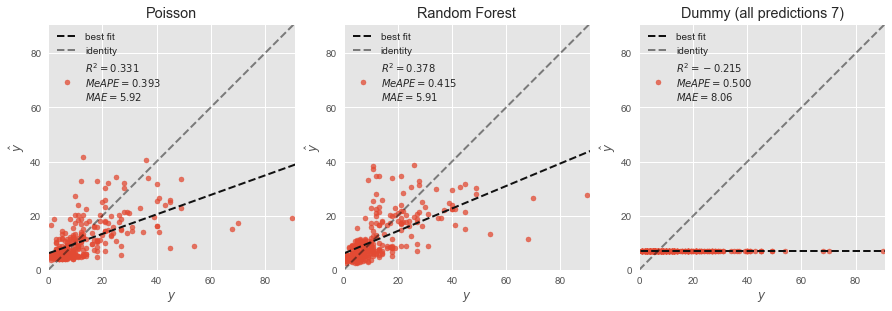

In [43]:
f, axarr = plt.subplots(1,3,figsize=(15,5))
prediction_error(y_true,y_pred_pr,axarr[0]) # plot
axarr[0].set_title("Poisson")

prediction_error(y_true,y_pred_rf,axarr[1]) # plot
axarr[1].set_title("Random Forest")

prediction_error(y_true,y_pred_dummy,axarr[2]) # plot
axarr[2].set_title("Dummy (all predictions 7)")

Text(0.5, 1.0, 'Dummy (all predictions 7)')

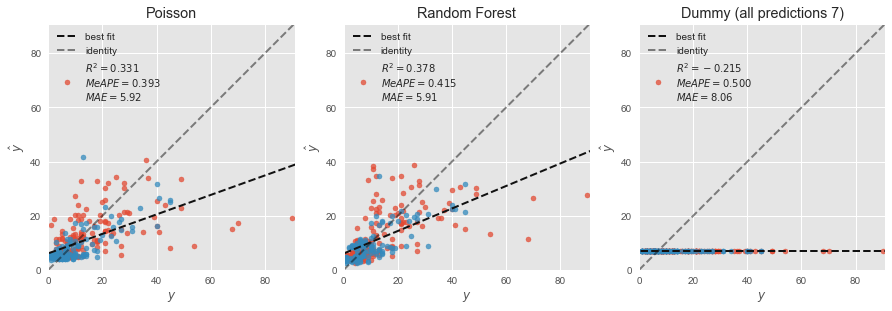

In [44]:
df['pop_pred'] = y_pred_pr
f, axarr = plt.subplots(1,3,figsize=(15,5))
prediction_error(y_true,y_pred_pr,axarr[0],color=True,df=df) # plot
axarr[0].set_title("Poisson")

df['pop_pred'] = y_pred_rf
prediction_error(y_true,y_pred_rf,axarr[1],color=True,df=df) # plot
axarr[1].set_title("Random Forest")

df['pop_pred'] = y_pred_dummy
prediction_error(y_true,y_pred_dummy,axarr[2],color=True,df=df) # plot
axarr[2].set_title("Dummy (all predictions 7)")

In [ ]:
df['pop_pred'] = y_pred_pr

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
prediction_error(y_true,y_pred_pr,ax=ax,df=df,images=True,tiles_path=tiles_path) # plot
ax.set_title("Poisson")
f.tight_layout()
f.savefig('image_error_plot_large.png',dpi=1000)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
prediction_error(y_true,y_pred_pr,ax=ax,df=df,images=True,buildings=True,tiles_path=tiles_path) # plot
ax.set_title("Poisson")
f.tight_layout()
f.savefig('building_error_plot_large.png',dpi=1000)